<a href="https://colab.research.google.com/github/Zardian18/Celeb-Faces-Comparision/blob/master/SAGAN_faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/Zardian18/helper-functions-colab/master/helper.py

--2024-02-27 09:09:55--  https://raw.githubusercontent.com/Zardian18/helper-functions-colab/master/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17171 (17K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]  16.77K  --.-KB/s    in 0.001s  

2024-02-27 09:09:55 (21.7 MB/s) - ‘helper.py’ saved [17171/17171]



In [2]:
!pip install kaggle

In [3]:
from google.colab import drive
drive.mount("/content/drive")

! mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

Mounted at /content/drive


In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks, utils, metrics, losses, optimizers, activations
from helper import sample_batch, display
import pandas as pd
import numpy as np
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

In [5]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Layer, Dense, Input, LeakyReLU, Reshape, Conv2D, Dense, Embedding
from tensorflow.keras.layers import UpSampling2D, AveragePooling2D, GlobalAveragePooling2D, Flatten
from tensorflow.keras.activations import relu, tanh
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import RMSprop, Adam
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')
print("Tensorflow", tf.__version__)

from packaging.version import parse as parse_version
# assert parse_version(tf.__version__) < parse_version("2.4.0"), \
#     f"Please install TensorFlow version 2.3.1 or older. Your current version is {tf.__version__}."

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
logical_gpus = tf.config.experimental.list_logical_devices('GPU')
print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")

Tensorflow 2.15.0
1 Physical GPUs, 1 Logical GPU


In [6]:
! kaggle datasets download -d jessicali9530/celeba-dataset

 99% 1.32G/1.33G [00:12<00:00, 160MB/s]
100% 1.33G/1.33G [00:12<00:00, 116MB/s]


In [7]:
!unzip celeba-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: img_align_celeba/img_align_celeba/197605.jpg  
  inflating: img_align_celeba/img_align_celeba/197606.jpg  
  inflating: img_align_celeba/img_align_celeba/197607.jpg  
  inflating: img_align_celeba/img_align_celeba/197608.jpg  
  inflating: img_align_celeba/img_align_celeba/197609.jpg  
  inflating: img_align_celeba/img_align_celeba/197610.jpg  
  inflating: img_align_celeba/img_align_celeba/197611.jpg  
  inflating: img_align_celeba/img_align_celeba/197612.jpg  
  inflating: img_align_celeba/img_align_celeba/197613.jpg  
  inflating: img_align_celeba/img_align_celeba/197614.jpg  
  inflating: img_align_celeba/img_align_celeba/197615.jpg  
  inflating: img_align_celeba/img_align_celeba/197616.jpg  
  inflating: img_align_celeba/img_align_celeba/197617.jpg  
  inflating: img_align_celeba/img_align_celeba/197618.jpg  
  inflating: img_align_celeba/img_align_celeba/197619.jpg  
  inflating: img_align_celeba/img_align_celeba/19

In [8]:
train_data = utils.image_dataset_from_directory(
    "/content/img_align_celeba",
    labels= None,
    color_mode= "rgb",
    image_size=(64,64),
    batch_size=32,
    shuffle = True,
    seed=42,
    interpolation= "bilinear"
)
train_data

Found 202599 files belonging to 1 classes.


<_PrefetchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

In [9]:
def preprocess(imgs):
  imgs = (tf.cast(imgs, "float32")-127.5)/127.5
  return imgs

train = train_data.map(lambda x: preprocess(x))

In [10]:
train

<_MapDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

In [11]:
import tensorflow as tf

def add_labels(image):
    labels = tf.zeros_like(image[:, 0, 0, 0], dtype=tf.int32)
    return image, labels

train_with_labels = train.map(add_labels)

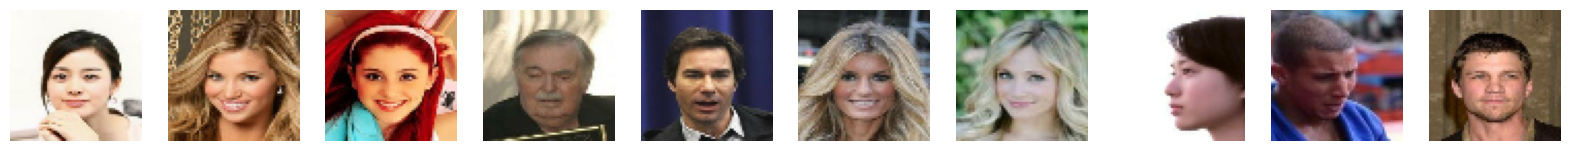

In [12]:
display(sample_batch(train))

In [13]:
train_with_labels

<_MapDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [14]:
# train= train.batch(128).repeat()

In [15]:
# train

In [16]:
class SpectralNorm(tf.keras.constraints.Constraint):
    def __init__(self, n_iter=5):
        self.n_iter = n_iter

    def call(self, input_weights):
        w = tf.reshape(input_weights, (-1, input_weights.shape[-1]))
        u = tf.random.normal((w.shape[0], 1))
        for _ in range(self.n_iter):
            v = tf.matmul(w, u, transpose_a=True)
            v /= tf.norm(v)

            u = tf.matmul(w, v)
            u /= tf.norm(u)

        spec_norm = tf.matmul(u, tf.matmul(w, v), transpose_a=True)
        return input_weights/spec_norm

In [17]:
class SelfAttention(Layer):
    def __init__(self):
        super(SelfAttention, self).__init__()

    def build(self, input_shape):
        n, h, w, c = input_shape
        self.n_feats = h * w
        self.conv_theta = Conv2D(c//8, 1, padding='same',
                                 kernel_constraint=SpectralNorm(), name='Conv_Theta')
        self.conv_phi = Conv2D(c//8, 1, padding='same',
                               kernel_constraint=SpectralNorm(), name='Conv_Phi')
        self.conv_g = Conv2D(c//2, 1, padding='same',
                             kernel_constraint=SpectralNorm(), name='Conv_G')
        self.conv_attn_g = Conv2D(c, 1, padding='same',
                                  kernel_constraint=SpectralNorm(), name='Conv_AttnG')
        self.sigma = self.add_weight(shape=[1],
                                initializer='zeros',
                                trainable=True, name='sigma')


    def call(self, x):
        n, h, w, c = x.shape
        theta = self.conv_theta(x)
        theta = tf.reshape(theta, (-1, self.n_feats, theta.shape[-1]))

        phi = self.conv_phi(x)
        phi = tf.nn.max_pool2d(phi, ksize=2, strides=2, padding='VALID')
        phi = tf.reshape(phi, (-1, self.n_feats//4, phi.shape[-1]))

        attn = tf.matmul(theta, phi, transpose_b=True)
        attn = tf.nn.softmax(attn)

        g = self.conv_g(x)
        g = tf.nn.max_pool2d(g, ksize=2, strides=2, padding='VALID')
        g = tf.reshape(g, (-1, self.n_feats//4, g.shape[-1]))

        attn_g = tf.matmul(attn, g)
        attn_g = tf.reshape(attn_g, (-1, h, w, attn_g.shape[-1]))
        attn_g = self.conv_attn_g(attn_g)

        output = x + self.sigma * attn_g

        return output

In [18]:
class ConditionBatchNorm(Layer):
    def __init__(self, n_class=2, decay_rate=0.999, eps=1e-7):
        super(ConditionBatchNorm, self).__init__()
        self.n_class = n_class
        self.decay = decay_rate
        self.eps = 1e-5

    def build(self, input_shape):
        self.input_size = input_shape
        n, h, w, c = input_shape

        self.gamma = self.add_weight(shape=[self.n_class, c],
                                    initializer='ones',
                                    trainable=True, name='gamma')

        self.beta = self.add_weight(shape=[self.n_class, c],
                                    initializer='zeros',
                                    trainable=True, name='beta')

        self.moving_mean = self.add_weight(shape=[1, 1, 1, c], initializer='zeros',
                                          trainable=False, name='moving_mean')

        self.moving_var = self.add_weight(shape=[1, 1, 1, c], initializer='ones',
                                          trainable=False, name='moving_var')

    def call(self, x, labels, training=False):

        beta = tf.gather(self.beta, labels)
        beta = tf.expand_dims(beta, 1)
        gamma = tf.gather(self.gamma, labels)
        gamma = tf.expand_dims(gamma, 1)

        if training:
            mean, var = tf.nn.moments(x, axes=(0,1,2), keepdims=True)
            self.moving_mean.assign(self.decay * self.moving_mean + (1-self.decay)*mean)
            self.moving_var.assign(self.decay * self.moving_var + (1-self.decay)*var)
            output = tf.nn.batch_normalization(x, mean, var, beta, gamma, self.eps)

        else:
            output = tf.nn.batch_normalization(x,
                                               self.moving_mean, self.moving_var,
                                               beta, gamma, self.eps)

        return output

In [19]:
# class Resblock(Layer):
#     def __init__(self, filters, n_class):
#         super(Resblock, self).__init__(name=f'g_resblock_{filters}x{filters}')
#         self.filters = filters
#         self.n_class = n_class

#     def build(self, input_shape):
#         input_filter = input_shape[-1]
#         self.conv_1 = Conv2D(self.filters, 3, padding='same', name='conv2d_1',
#                             kernel_constraint=SpectralNorm())
#         self.conv_2 = Conv2D(self.filters, 3, padding='same', name='conv2d_2',
#                              kernel_constraint=SpectralNorm())
#         self.cbn_1 = ConditionBatchNorm(self.n_class)
#         self.cbn_2 = ConditionBatchNorm(self.n_class)
#         self.learned_skip = False

#         if self.filters != input_filter:
#             self.learned_skip = True
#             self.conv_3 = Conv2D(self.filters, 1, padding='same', name='conv2d_3',
#                                 kernel_constraint=SpectralNorm())
#             self.cbn_3 = ConditionBatchNorm(self.n_class)

#     def call(self, input_tensor, labels):
#         x = self.conv_1(input_tensor)
#         x = self.cbn_1(x, labels)
#         x = tf.nn.leaky_relu(x, 0.2)

#         x = self.conv_2(x)
#         x = self.cbn_2(x, labels)
#         x = tf.nn.leaky_relu(x, 0.2)

#         if self.learned_skip:
#             skip = self.conv_3(input_tensor)
#             skip = self.cbn_3(skip, labels)
#             skip = tf.nn.leaky_relu(skip, 0.2)
#         else:
#             skip = input_tensor

#         output = skip + x
#         return output

# def build_generator(z_dim, n_class):

#     DIM = 64

#     z = layers.Input(shape=(z_dim))
#     labels = layers.Input(shape=(1), dtype='int32')

#     x = Dense(4*4*4*DIM, kernel_constraint=SpectralNorm())(z)
#     x = layers.Reshape((4, 4, 4*DIM))(x)

#     x = layers.UpSampling2D((2,2))(x)
#     x = Resblock(4*DIM, n_class)(x, labels)

#     x = layers.UpSampling2D((2,2))(x)
#     x = Resblock(2*DIM, n_class)(x, labels)

#     x = SelfAttention()(x)

#     x = layers.UpSampling2D((2,2))(x)
#     x = Resblock(DIM, n_class)(x, labels)

#     output_image = tanh(Conv2D(3, 3, padding='same', kernel_constraint=SpectralNorm())(x))

#     return Model([z, labels],
#                  output_image,
#                  name='generator')

In [20]:
# class ResblockDown(Layer):
#     def __init__(self, filters, downsample=True):
#         super(ResblockDown, self).__init__()
#         self.filters = filters
#         self.downsample = downsample

#     def build(self, input_shape):
#         input_filter = input_shape[-1]
#         self.conv_1 = Conv2D(self.filters, 3, padding='same', kernel_constraint=SpectralNorm())
#         self.conv_2 = Conv2D(self.filters, 3, padding='same', kernel_constraint=SpectralNorm())
#         self.learned_skip = False

#         if self.filters != input_filter:
#             self.learned_skip = True
#             self.conv_3 = Conv2D(self.filters, 1, padding='same', kernel_constraint=SpectralNorm())

#     def down(self, x):
#         return tf.nn.avg_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], 'VALID')

#     def call(self, input_tensor):
#         x = self.conv_1(input_tensor)
#         x = tf.nn.leaky_relu(x, 0.2)

#         x = self.conv_2(x)
#         x = tf.nn.leaky_relu(x, 0.2)

#         if self.downsample:
#             x = self.down(x)

#         if self.learned_skip:
#             skip = self.conv_3(input_tensor)
#             skip = tf.nn.leaky_relu(skip, 0.2)
#             if self.downsample:
#                 skip = self.down(skip)
#         else:
#             skip = input_tensor
#         output = skip + x
#         return output

In [21]:
# def build_discriminator(n_class):
#     DIM = 64
#     input_image = Input(shape=(32,32,3))
#     input_labels = Input(shape=(1))

#     embedding = Embedding(n_class, 4*DIM)(input_labels)

#     embedding = Flatten()(embedding)

#     x = ResblockDown(DIM)(input_image) # 64

#     x = ResblockDown(2*DIM)(x) # 32

#     x = SelfAttention()(x)

#     x = ResblockDown(4*DIM)(x) # 16

#     x = ResblockDown(4*DIM, False)(x) # 4

#     x = tf.reduce_sum(x, (1, 2))

#     embedded_x  = tf.reduce_sum(x * embedding, axis=1,  keepdims=True)

#     output = Dense(1)(x)

#     output += embedded_x

#     return Model([input_image, input_labels], output, name='discriminator')

In [28]:
class Resblock(Layer):
    def __init__(self, filters, n_class):
        super(Resblock, self).__init__(name=f'g_resblock_{filters}x{filters}')
        self.filters = filters
        self.n_class = n_class

    def build(self, input_shape):
        input_filter = input_shape[-1]
        self.conv_1 = Conv2D(self.filters, 3, padding='same', name='conv2d_1', kernel_constraint=SpectralNorm())
        self.conv_2 = Conv2D(self.filters, 3, padding='same', name='conv2d_2', kernel_constraint=SpectralNorm())
        self.cbn_1 = ConditionBatchNorm(self.n_class)
        self.cbn_2 = ConditionBatchNorm(self.n_class)
        self.learned_skip = False

        if self.filters != input_filter:
            self.learned_skip = True
            self.conv_3 = Conv2D(self.filters, 1, padding='same', name='conv2d_3', kernel_constraint=SpectralNorm())
            self.cbn_3 = ConditionBatchNorm(self.n_class)

    def call(self, input_tensor, labels):
        x = self.conv_1(input_tensor)
        x = self.cbn_1(x, labels)
        x = tf.nn.leaky_relu(x, 0.2)

        x = self.conv_2(x)
        x = self.cbn_2(x, labels)
        x = tf.nn.leaky_relu(x, 0.2)

        if self.learned_skip:
            skip = self.conv_3(input_tensor)
            skip = self.cbn_3(skip, labels)
            skip = tf.nn.leaky_relu(skip, 0.2)
        else:
            skip = input_tensor

        output = skip + x
        return output


class ResblockDown(Layer):
    def __init__(self, filters, downsample=True):
        super(ResblockDown, self).__init__()
        self.filters = filters
        self.downsample = downsample

    def build(self, input_shape):
        input_filter = input_shape[-1]
        self.conv_1 = Conv2D(self.filters, 3, padding='same', kernel_constraint=SpectralNorm())
        self.conv_2 = Conv2D(self.filters, 3, padding='same', kernel_constraint=SpectralNorm())
        self.learned_skip = False

        if self.filters != input_filter:
            self.learned_skip = True
            self.conv_3 = Conv2D(self.filters, 1, padding='same', kernel_constraint=SpectralNorm())

    def down(self, x):
        return AveragePooling2D((2, 2))(x)

    def call(self, input_tensor):
        x = self.conv_1(input_tensor)
        x = tf.nn.leaky_relu(x, 0.2)

        x = self.conv_2(x)
        x = tf.nn.leaky_relu(x, 0.2)

        if self.downsample:
            x = self.down(x)

        if self.learned_skip:
            skip = self.conv_3(input_tensor)
            skip = tf.nn.leaky_relu(skip, 0.2)
            if self.downsample:
                skip = self.down(skip)
        else:
            skip = input_tensor
        output = skip + x
        return output

# DIM = 128

# def build_generator(z_dim, n_class):
#     z = Input(shape=(z_dim,))
#     labels = Input(shape=(1,), dtype='int32')

#     x = Dense(4 * 4 * 8 * DIM, kernel_constraint=SpectralNorm())(z)
#     x = Reshape((4, 4, 8 * DIM))(x)

#     x = UpSampling2D((2, 2))(x)
#     x = Resblock(8 * DIM, n_class)(x, labels)

#     x = UpSampling2D((2, 2))(x)
#     x = Resblock(4 * DIM, n_class)(x, labels)

#     x = SelfAttention()(x)

#     x = UpSampling2D((2, 2))(x)
#     x = Resblock(2 * DIM, n_class)(x, labels)

#     x = UpSampling2D((2, 2))(x)
#     x = Resblock(DIM, n_class)(x, labels)

#     x = UpSampling2D((2, 2))(x)
#     x = Resblock(DIM // 2, n_class)(x, labels)

#     output_image = tf.keras.activations.tanh(Conv2D(3, 3, padding='same', kernel_constraint=SpectralNorm())(x))

#     return Model([z, labels], output_image, name='generator')


# def build_discriminator(n_class):
#     input_image = Input(shape=(64, 64, 3))
#     input_labels = Input(shape=(1,))

#     embedding = Embedding(n_class, 8 * DIM)(input_labels)
#     embedding = Flatten()(embedding)

#     x = ResblockDown(8 * DIM)(input_image)  # 32

#     x = ResblockDown(4 * DIM)(x)  # 16

#     x = SelfAttention()(x)

#     x = ResblockDown(2 * DIM)(x)  # 8

#     x = ResblockDown(DIM)(x)  # 4

#     x = tf.reduce_sum(x, (1, 2))

#     embedded_x = tf.reduce_sum(x * embedding, axis=1, keepdims=True)

#     output = Dense(1)(x)

#     output += embedded_x

#     return Model([input_image, input_labels], output, name='discriminator')

def build_generator(z_dim, n_class):
    DIM = 64

    z = Input(shape=(z_dim,))
    labels = Input(shape=(1,), dtype='int32')

    x = Dense(4 * 4 * 4 * DIM, kernel_constraint=SpectralNorm())(z)
    x = Reshape((4, 4, 4 * DIM))(x)

    x = UpSampling2D((2, 2))(x)
    x = Resblock(4 * DIM, n_class)(x, labels)

    x = UpSampling2D((2, 2))(x)
    x = Resblock(2 * DIM, n_class)(x, labels)

    x = SelfAttention()(x)

    x = UpSampling2D((2, 2))(x)
    x = Resblock(DIM, n_class)(x, labels)

    x = UpSampling2D((2, 2))(x)
    x = Resblock(DIM // 2, n_class)(x, labels)

    output_image = tf.keras.activations.tanh(Conv2D(3, 3, padding='same', kernel_constraint=SpectralNorm())(x))

    return Model([z, labels], output_image, name='generator')



def build_discriminator(n_class):
    DIM = 64
    input_image = Input(shape=(64, 64, 3))
    input_labels = Input(shape=(1,))

    embedding = Embedding(n_class, 4 * DIM)(input_labels)
    embedding = Flatten()(embedding)

    x = ResblockDown(DIM)(input_image)  # 32

    x = ResblockDown(2 * DIM)(x)  # 16

    x = SelfAttention()(x)

    x = ResblockDown(4 * DIM)(x)  # 8

    x = ResblockDown(4 * DIM, False)(x)  # 4

    x = tf.reduce_sum(x, (1, 2))

    embedded_x = tf.reduce_sum(x * embedding, axis=1, keepdims=True)

    output = Dense(1)(x)

    output += embedded_x

    return Model([input_image, input_labels], output, name='discriminator')

In [33]:
def hinge_loss_d(y_true, y_pred):
    return tf.keras.losses.Hinge()(y_pred, y_true)

def hinge_loss_g(y_true, y_pred):
    return -tf.reduce_mean(y_pred)


class SAGAN():
    def __init__(self, image_shape, n_class, z_dim=128):
        self.z_dim = z_dim
        self.n_class = n_class

        # Build models
        self.optimizer_d = Adam(4e-4, 0.0, 0.9)
        self.optimizer_g = Adam(1e-4, 0.0, 0.9)
        self.discriminator = build_discriminator(n_class)

        self.generator = build_generator(z_dim, n_class)

        pred = self.discriminator([self.generator.output, self.generator.input[1]])
        self.model = Model(self.generator.input, pred, name='model')
        self.model.compile(optimizer=self.optimizer_g, loss=hinge_loss_g)


        self.hinge_loss = tf.keras.losses.Hinge()

    def hinge_loss_d(self, y, is_real):
        label = 1. if is_real else -1.
        loss = self.hinge_loss(y, label)
        return loss

    def hinge_loss_g(self, y):
        return -tf.reduce_mean(y)

    def train_step(self, train_gen):
        real_images, real_class_labels = next(train_gen)
        batch_size = real_class_labels.shape[0]
        real_labels = 1
        fake_labels = 0

        z = tf.random.normal((batch_size, self.z_dim))
        #fake_class_labels = tf.random.uniform([batch_size], 0, self.n_class, tf.int32)
        fake_class_labels = real_class_labels

        with tf.GradientTape() as d_tape, \
             tf.GradientTape() as g_tape:

            # forward pass
            fake_images = self.generator([z, fake_class_labels])
            pred_real = self.discriminator([real_images, real_class_labels])
            pred_fake = self.discriminator([fake_images, fake_class_labels])

            # discriminator losses
            loss_fake = self.hinge_loss_d(pred_fake, False)
            loss_real = self.hinge_loss_d(pred_real, True)

            # total loss
            d_loss = 0.5*(loss_fake + loss_real)
            d_gradients = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.optimizer_d.apply_gradients(zip(d_gradients, self.discriminator.trainable_variables))

            # Generator Loss
            g_loss = self.hinge_loss_g(pred_fake)
            g_gradients = g_tape.gradient(g_loss, self.generator.trainable_variables)
            self.optimizer_g.apply_gradients(zip(g_gradients, self.generator.trainable_variables))


        return g_loss, d_loss

    def show_val(self):
        images_per_class = 5
        z = tf.random.normal((images_per_class*self.n_class, self.z_dim))
        labels = []
        for i in range(self.n_class):
            labels += [i]*images_per_class
        labels = np.array(labels, dtype=np.int32)

        images = self.generator.predict([z, labels])
        images = images * 0.5 + 0.5
        grid_row = self.n_class
        grid_col = images_per_class

        scale = 2
        f, axarr = plt.subplots(grid_row, grid_col,
                                figsize=(grid_col*scale, grid_row*scale))

        for row in range(grid_row):
            ax = axarr if grid_row==1 else axarr[row]
            for col in range(grid_col):
                ax[col].imshow(images[row*grid_col + col])
                ax[col].axis('off')
        plt.show()


    def train(self, train_gen, steps, interval=100):
        for i in range(steps):
            g_loss, d_loss = self.train_step(train_gen)
            if i% interval == 0:
                msg = f'Step {i} g_loss {g_loss:.4f} d_loss {d_loss:.4f}'
                print(msg)
                self.show_val()


In [34]:
tf.keras.backend.clear_session()
saganx = SAGAN((64,64,3), 1)

In [35]:
saganx.generator.summary()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 dense_1 (Dense)             (None, 4096)                 528384    ['input_3[0][0]']             
                                                                                                  
 reshape (Reshape)           (None, 4, 4, 256)            0         ['dense_1[0][0]']             
                                                                                                  
 up_sampling2d (UpSampling2  (None, 8, 8, 256)            0         ['reshape[0][0]']             
 D)                                                                                       

In [36]:
saganx.discriminator.summary()

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 resblock_down (ResblockDow  (None, 32, 32, 64)           38976     ['input_1[0][0]']             
 n)                                                                                               
                                                                                                  
 resblock_down_1 (ResblockD  (None, 16, 16, 128)          229760    ['resblock_down[0][0]']       
 own)                                                                                             
                                                                                      

In [37]:
saganx.generator.compile(loss=saganx.hinge_loss)

Step 0 g_loss 5.1612 d_loss 9.3146
1/1 [==============================] - 1s 1s/step


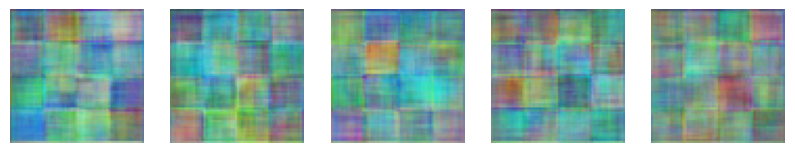

Step 250 g_loss 3.0173 d_loss 0.1132
1/1 [==============================] - 0s 23ms/step


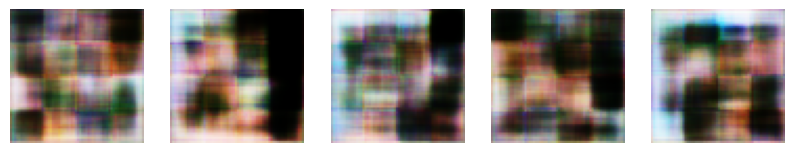

Step 500 g_loss 1.8231 d_loss 0.7992
1/1 [==============================] - 0s 22ms/step


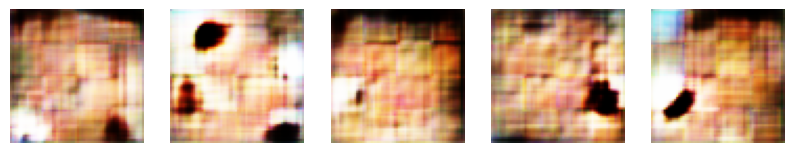

Step 750 g_loss 3.6078 d_loss 0.4016
1/1 [==============================] - 0s 21ms/step


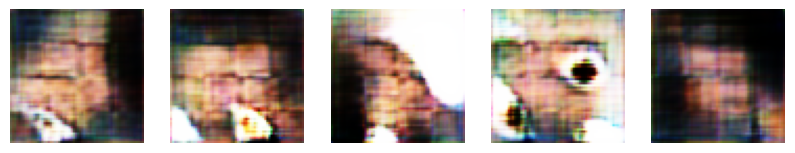

Step 1000 g_loss 4.5638 d_loss 0.1996
1/1 [==============================] - 0s 22ms/step


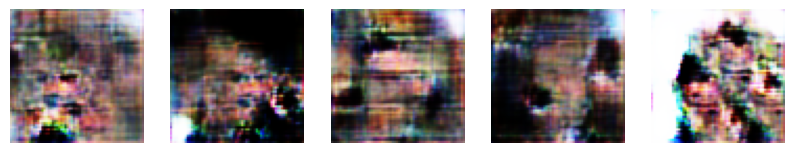

Step 1250 g_loss 2.6840 d_loss 0.0097
1/1 [==============================] - 0s 23ms/step


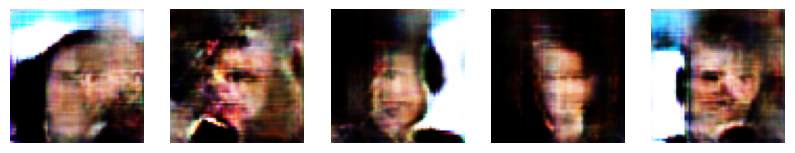

Step 1500 g_loss 4.7930 d_loss 0.4651
1/1 [==============================] - 0s 23ms/step


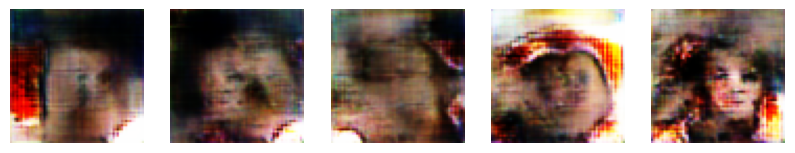

Step 1750 g_loss 3.0036 d_loss 0.1003
1/1 [==============================] - 0s 21ms/step


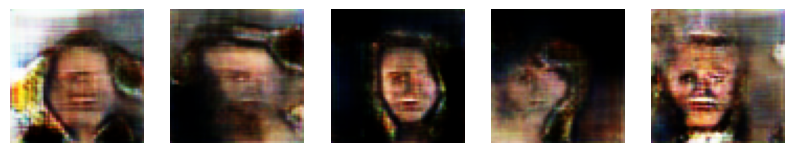

Step 2000 g_loss 1.9741 d_loss 0.0000
1/1 [==============================] - 0s 23ms/step


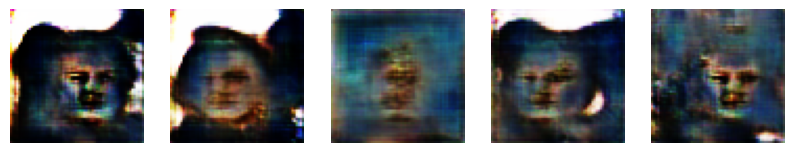

Step 2250 g_loss 2.0086 d_loss 0.1417
1/1 [==============================] - 0s 22ms/step


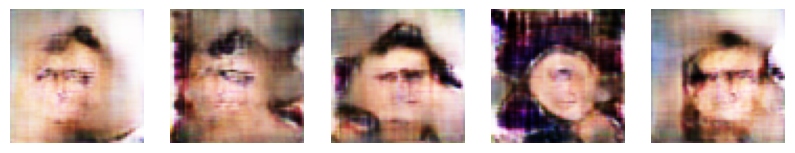

In [38]:
saganx.train(iter(train_with_labels), 2500, 250)

1/1 [==============================] - 0s 37ms/step


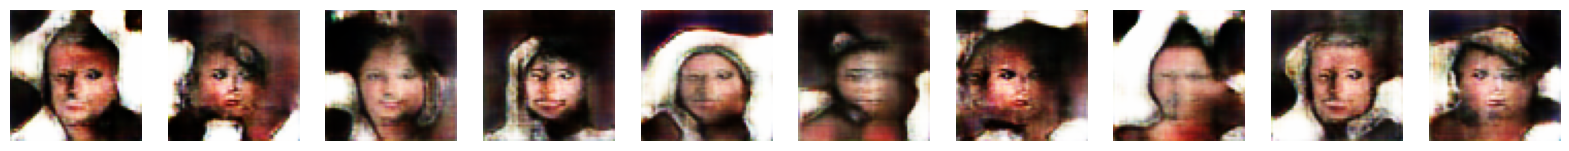

In [42]:
images_per_class = 10
z = tf.random.normal((images_per_class*saganx.n_class, saganx.z_dim))
labels = []
for i in range(saganx.n_class):
    labels += [i]*images_per_class
labels = np.array(labels, dtype=np.int32)

images = saganx.generator.predict([z, labels])
images = images * 0.5 + 0.5
grid_row = saganx.n_class
grid_col = images_per_class

scale = 2
f, axarr = plt.subplots(grid_row, grid_col,
                        figsize=(grid_col*scale, grid_row*scale))

for row in range(grid_row):
    ax = axarr if grid_row==1 else axarr[row]
    for col in range(grid_col):
        ax[col].imshow(images[row*grid_col + col])
        ax[col].axis('off')
plt.show()

1/1 [==============================] - 1s 751ms/step


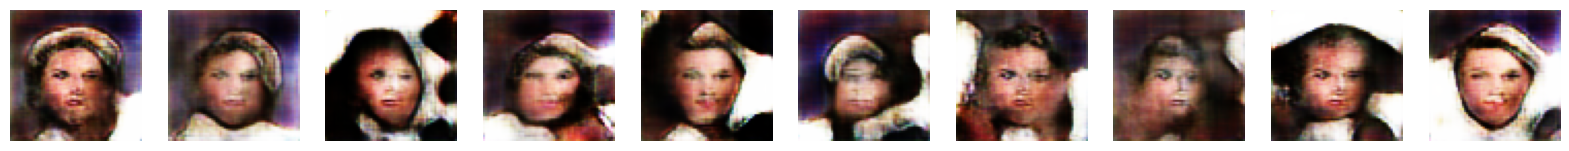

In [41]:
images_per_class = 10
z = tf.random.normal((images_per_class*saganx.n_class, saganx.z_dim))
labels = []
for i in range(saganx.n_class):
    labels += [i]*images_per_class
labels = np.array(labels, dtype=np.int32)

images = saganx.generator.predict([z, labels])
images = images * 0.5 + 0.5
grid_row = saganx.n_class
grid_col = images_per_class

scale = 2
f, axarr = plt.subplots(grid_row, grid_col,
                        figsize=(grid_col*scale, grid_row*scale))

for row in range(grid_row):
    ax = axarr if grid_row==1 else axarr[row]
    for col in range(grid_col):
        ax[col].imshow(images[row*grid_col + col])
        ax[col].axis('off')
plt.show()